In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cbf_opt import dynamics, cbf, utils, asif
from refine_cbfs import cbf as cbf_hjr, dynamics as dynamics_hjr
import hj_reachability as hj
import jax.numpy as jnp
import numpy as np

In [3]:
import matplotlib
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': '32',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'lines.linewidth': 6.,
})
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import seaborn as sns

State: $\mathbf{x} = [y, v_y, \phi, \omega]^T$

Dynamics: 
$$\dot{x} = \begin{bmatrix}x_2 \\ \frac{ - C_D^v x_2}{m} - g \\ x_4 \\ \frac{- C_D^\phi x_4}{I{yy}}\end{bmatrix} + \begin{bmatrix}0 & 0 \\ \frac{\cos(x_3)}{m} & \frac{\cos(x_3)}{m} \\ 0 & 0 \\ -\frac{l}{I_{yy}} & \frac{l}{I_{yy}}\end{bmatrix}\underbrace{\begin{bmatrix}T_1 \\ T_2\end{bmatrix}}_{u}

In [4]:
class QuadVerticalDynamics(dynamics.ControlAffineDynamics):
    def __init__(self, params, **kwargs):
        params['n_dims'] = 4
        params['control_dims'] = 2

        self.Cd_v = params["Cd_v"]
        self.g = params["g"]
        self.Cd_phi = params["Cd_phi"]
        self.mass = params["mass"]
        self.length = params["length"]
        self.Iyy = params["Iyy"]
        super().__init__(params, **kwargs)

    
    def open_loop_dynamics(self, state, time=0.0):
        return jnp.array([
            state[1], 
            -state[1] * self.Cd_v / self.mass - self.g, 
            state[3], 
            -state[3] * self.Cd_phi / self.Iyy
            ])
    
    def control_matrix(self, state, time=0.0):
        return jnp.array([
            [0, 0], 
            [jnp.cos(state[2]) / self.mass, jnp.cos(state[2]) / self.mass], 
            [0, 0], 
            [-self.length / self.Iyy, self.length / self.Iyy]
            ])

    def state_jacobian(self, state, control, time=0.):
        return np.array([
            [0., 1., 0., 0.],
            [0., -self.Cd_v / self.mass, (-control[0] + control[1]) * np.sin(state[2]) / self.mass, 0.],
            [0., 0., 0., 1.],
            [0., 0., 0., -self.Cd_phi / self.Iyy]
        ])
    

In [5]:
params = dict()
params["Cd_v"] = 0.25
params["g"] = 9.81
params["Cd_phi"] = 0.02255
params["mass"] = 2.5
params["length"] = 1.0
params["Iyy"] = 1.0
params["dt"] = 0.01

dyn = QuadVerticalDynamics(params)

In [6]:
umax = 0.75 * params["mass"] * params["g"] * jnp.ones(2)
umin = jnp.zeros_like(umax)

## Safe set: 
$$\mathcal{E} = [1, 9] \times [-6, 6] \times [-\infty, \infty] \times [-8,8]$$

In [7]:
def safe_set(state):
    """A real-valud function s.t. the zero-superlevel set is the safe set

    Args:
        state : An unbatched (!) state vector, an array of shape `(4,)` containing `[y, v_y, phi, omega]`.

    Returns:
        A scalar, positive iff the state is in the safe set
    """
    return jnp.min(jnp.array([state[0] - 1, 9 - state[0], state[1] + 6, 6 - state[1], state[3] + 8, 8 - state[3]]))


Two options: We learn a value function that indicates backup set (in a small region of the state space maybe around the hovering) and an unsafe region (outside of the operating range) OR we define a CBF ourselves with a bit of imagination

## Current implementation: Self-defined approximately correct value function

## Classical HJ solution

In [8]:
dyn_hjr = dynamics_hjr.HJControlAffineDynamics(dyn, control_space=hj.sets.Box(jnp.array(umin), jnp.array(umax)))

state_domain = hj.sets.Box(lo=jnp.array([0., -8., -jnp.pi, -10.]), hi=jnp.array([10., 8., jnp.pi, 10.]))
grid_resolution = (31, 25, 41, 25)  # can/should be increased if running on GPU, or if extra patient

In [9]:
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(state_domain, grid_resolution, periodic_dims=2)

extended_state_domain = hj.sets.Box(lo=jnp.array([-20, -8, 0., -8., -jnp.pi, -10.]), hi=jnp.array([20, 8, 10., 8., jnp.pi, 10.]))
extended_grid_resolution = (5, 5, 31, 25, 41, 25) 
extended_grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(extended_state_domain, extended_grid_resolution, periodic_dims=4)

In [10]:
safe_values = hj.utils.multivmap(safe_set, jnp.arange(4))(grid.states)

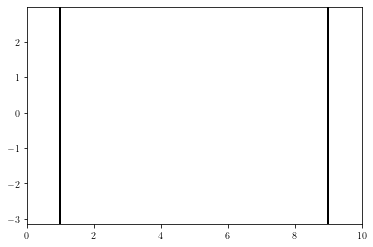

In [14]:
fig, ax = plt.subplots()
ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[2], safe_values[:, 12, :, 12].T, levels=[0.0], colors='k', linewidths=2)

In [11]:
backwards_reachable_tube = lambda obstacle: (lambda t, x: jnp.minimum(x, obstacle))
solver_settings = hj.SolverSettings.with_accuracy("very_high", value_postprocessor=backwards_reachable_tube(safe_values))

In [12]:
init_values = safe_values
initial_time = 0.
final_time = -20.
times = jnp.linspace(initial_time, final_time, 101)
# target_values_hjr = hj.step(solver_settings, dyn_hjr, grid, initial_time, init_values, final_time)
# np.save("quad_2d/target_values_hjr_last.npy", target_values_hjr)
target_values_hjr = np.load("quad_2d/target_values_hjr_last.npy")

# CBF HJR


## Online implementation

We consider the setting of having a linearized LQR nominal controller that attempts to stabilize us at a given point in the state space. Specifically, we consider a problem where we are "thrown" into the air by a user and we wish to stabilize the drone at a certain height (and possibly a non-constant angle)

Additionally we could include a 6D drone that include x positioning for the stabilizing behavior to get a more realistic scenario

AA203 text: Consider the goal of developing a self-righting quadrotor, i.e., a flying drone that you can chuck into the air at a range of poses/velocities which will autonomously regulate to level flight while obeying dynamics/controls/operational-envelope constraints.

In [13]:
class QuadPlanarDynamics(dynamics.ControlAffineDynamics):
    def __init__(self, params, **kwargs):
        params['n_dims'] = 6
        params['control_dims'] = 2

        self.Cd_v = params["Cd_v"]
        self.g = params["g"]
        self.Cd_phi = params["Cd_phi"]
        self.mass = params["mass"]
        self.length = params["length"]
        self.Iyy = params["Iyy"]
        super().__init__(params, **kwargs)

    
    def open_loop_dynamics(self, state, time=0.0):
        return np.array([
            state[1], 
            - state[1] * self.Cd_v / self.mass,
            state[3],
            - state[3] * self.Cd_v / self.mass - self.g,
            state[5], 
            -state[5] * self.Cd_phi / self.Iyy
            ])
    
    def state_jacobian(self, state, control, time=0.): # TODO: Should this include state[5]?
        return np.array([
            [0., 1., 0., 0., 0., 0.],
            [0., -self.Cd_v / self.mass, 0., 0., -(control[0] + control[1]) * np.cos(state[4]) / self.mass, 0.],
            [0., 0., 0., 1., 0., 0.],
            [0., 0., 0., -self.Cd_v / self.mass, (-control[0] + control[1]) * np.sin(state[4]) / self.mass, 0.],
            [0., 0., 0., 0., 0., 1.],
            [0., 0., 0., 0., 0., -self.Cd_phi / self.Iyy]
        ])
    def control_matrix(self, state, time=0.0):
        return np.array([
            [0, 0],
            [-np.sin(state[4]) / self.mass, -np.sin(state[4]) / self.mass],
            [0, 0], 
            [np.cos(state[4]) / self.mass, np.cos(state[4]) / self.mass], 
            [0, 0], 
            [-self.length / self.Iyy, self.length / self.Iyy]
            ])

In [14]:
control_at_rest = np.ones(2) * dyn.mass * dyn.g / 2.

## Creating a handcrafted CBF based on Lyapunov equations

In [15]:
extended_dyn = QuadPlanarDynamics(params)

Design an expert CBF

In [16]:
expert_cbf = lambda V, c, x_target: lambda x, t=0.: c - (x - x_target) @ V @ (x - x_target)

In [18]:
target_values = np.load("quad_2d/target_values_lyap_cbf_updated_march1st.npy")
quad_tabular_cbf = cbf_hjr.TabularControlAffineCBF(dyn, grid=grid)
quad_tabular_cbf.vf_table = target_values[0]
quad_tabular_cbvf = cbf_hjr.TabularControlAffineCBF(dyn, grid=grid)
quad_tabular_cbvf.vf_table = target_values[-1]

In [19]:
import pickle as pkl

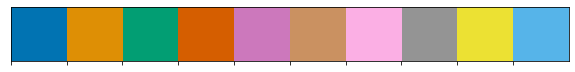

In [47]:
sns.palplot(sns.color_palette("colorblind", 10))

In [48]:
pal = sns.color_palette("colorblind")

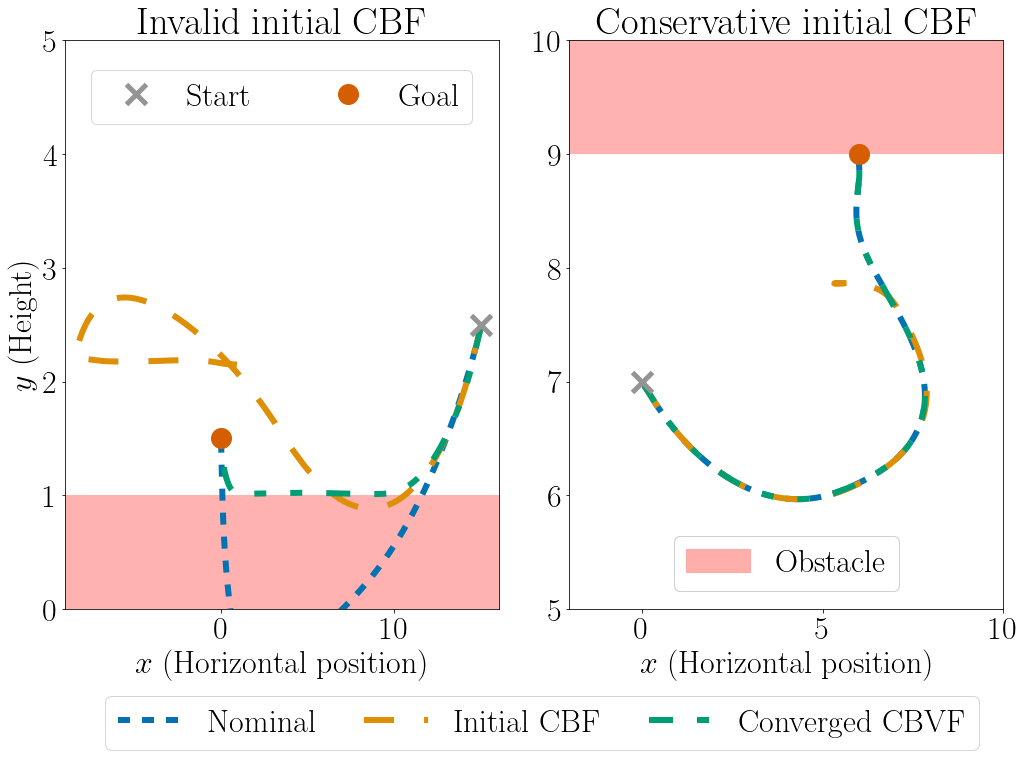

In [96]:
traj_data = pkl.load(open("quad_2d/traj_data_invalid_cbf.pkl", "rb"))
nominal = traj_data['nominal']
cbf_traj = traj_data['cbf']
cbvf_traj = traj_data['cbvf']
states = nominal['state']
control = nominal['control']
ts = nominal['times']
states_filt = cbf_traj['state']
control_filt = cbf_traj['control']
vf_filt = cbf_traj['vf']
states_filt_ws = cbvf_traj['state']
control_filt_ws = cbvf_traj['control']
vf_filt_ws = cbvf_traj['vf']
x_goal = traj_data['x_goal']
x0 = traj_data['x_start']

alt_colors = sns.color_palette("pastel", 9).as_hex()
fig, axs = plt.subplots(1, 2, figsize=(15,10))
ax = axs[0]
sns.set_palette("colorblind")
lim = -1
# ax.contourf(extended_grid.coordinate_vectors[0], extended_grid.coordinate_vectors[2], new_vf_vals[:, 2, :, 13, 15, 13].T, levels=[0, 100], colors='green', alpha=.2)
c1 = ax.plot(np.array(states)[:lim, 0], np.array(states)[:lim, 2], '--', dashes=(2, 2), label= 'Nominal')
c2 = ax.plot(np.array(states_filt)[:lim, 0], np.array(states_filt)[:lim, 2], ':', dashes=(5,5),label='Initial CBF')
c3 = ax.plot(np.array(states_filt_ws)[:lim, 0], np.array(states_filt_ws)[:lim, 2], label='Converged CBVF')
c3[0].set_dashes([4, 4, 2, 4, 2, 4]) 
# c1 = ax.plot(np.array(states)[:lim, 0], np.array(states)[:lim, 2], '--',  dashes=(5, 20), color=c1[0].get_color(), label= '__nolegend__')
l1 = ax.plot(x0[0], x0[2], 'x', markersize=20, mew=5, color=pal[7])
# ax.plot(np.array(states_filt)[-1, 0], np.array(states_filt)[-1, 2], 'x', markersize=20, mew=5, color=c2[0].get_color())
# ax.plot(np.array(states_filt_ws)[-1, 0], np.array(states_filt_ws)[-1, 2], 'x', markersize=20, mew=5, color=c3[0].get_color())
l2 = ax.plot(x_goal[0], x_goal[2], 'o', markersize=20, color=pal[3])

miscs = [l1, l2]
new_vals_broadcast = np.repeat(np.repeat(safe_values[np.newaxis, ...], 5, axis=0)[np.newaxis, ...], 5, axis=0)
cs = ax.contourf(extended_grid.coordinate_vectors[0], extended_grid.coordinate_vectors[2], new_vals_broadcast[:, 2, :, 13, 20, 13].T, levels=[-100, 0], colors=alt_colors[3], alpha=.8)
# get_drone(ax, x0[0], x0[2], x0[4])
ax.set_ylim([0, 5])
ax.set_xlim([-9,16])
ax.set_xlabel('$x$ (Horizontal position)')
ax.set_ylabel('$y$ (Height)')


traj_data = pkl.load(open("quad_2d/traj_data_conservative_cbf.pkl", "rb"))
nominal = traj_data['nominal']
cbf_traj = traj_data['cbf']
cbvf_traj = traj_data['cbvf']
states = nominal['state']
control = nominal['control']
ts = nominal['times']
states_filt = cbf_traj['state']
control_filt = cbf_traj['control']
vf_filt = cbf_traj['vf']
states_filt_ws = cbvf_traj['state']
control_filt_ws = cbvf_traj['control']
vf_filt_ws = cbvf_traj['vf']
x_goal = traj_data['x_goal']
x0 = traj_data['x_start']

ax = axs[1]
sns.set_palette("colorblind")
lim = -1
# ax.contourf(extended_grid.coordinate_vectors[0], extended_grid.coordinate_vectors[2], new_vf_vals[:, 2, :, 13, 15, 13].T, levels=[0, 100], colors='green', alpha=.2)
c1 = ax.plot(np.array(states)[:lim, 0], np.array(states)[:lim, 2], '--', dashes=(2, 2), label= '$u_{nom}$')
c2 = ax.plot(np.array(states_filt)[:lim, 0], np.array(states_filt)[:lim, 2], ':', dashes=(5,5),label='$u_{CBF}$')
c3 = ax.plot(np.array(states_filt_ws)[:lim, 0], np.array(states_filt_ws)[:lim, 2], label='$u_{CBVF}$')
c3[0].set_dashes([4, 4, 2, 4, 2, 4]) 
# c1 = ax.plot(np.array(states)[:lim, 0], np.array(states)[:lim, 2], '--',  dashes=(5, 20), color=c1[0].get_color(), label= '__nolegend__')
l1 = ax.plot(x0[0], x0[2], 'x', markersize=20, mew=5, color=pal[7])
# ax.plot(np.array(states_filt)[-1, 0], np.array(states_filt)[-1, 2], 'x', markersize=20, mew=5, color=c2[0].get_color())
# ax.plot(np.array(states_filt_ws)[-1, 0], np.array(states_filt_ws)[-1, 2], 'x', markersize=20, mew=5, color=c3[0].get_color())
l2 = ax.plot(x_goal[0], x_goal[2], 'o', markersize=20, color=pal[3])

miscs = [l1, l2]
new_vals_broadcast = np.repeat(np.repeat(safe_values[np.newaxis, ...], 5, axis=0)[np.newaxis, ...], 5, axis=0)
cs = ax.contourf(extended_grid.coordinate_vectors[0], extended_grid.coordinate_vectors[2], new_vals_broadcast[:, 2, :, 13, 20, 13].T, levels=[-100, 0], colors=alt_colors[3], alpha=.8)
proxy = []
proxy += [plt.Rectangle((0,0),1,1, fc=alt_colors[3], ec=alt_colors[3], alpha=0.8) for pc in cs.collections]
# get_drone(ax, x0[0], x0[2], x0[4])
ax.set_xlim([-2, 10])
ax.set_ylim([5,10])
ax.set_xlabel('$x$ (Horizontal position)')

fig.tight_layout()
axs[0].set_title('Invalid initial CBF')
axs[1].set_title('Conservative initial CBF')
leg = axs[0].legend([misc[0] for misc in miscs], ['Start', 'Goal'], ncol=2, bbox_to_anchor=[.5, 0.9], loc='center', frameon=True, handletextpad=0.6)
leg2 = axs[1].legend(proxy, ['Obstacle'], bbox_to_anchor=[0.5, 0.08], loc='center', frameon=True)
axs[0].legend(bbox_to_anchor=[1.1, -.2], ncol=3, columnspacing=1.5, handletextpad=0.8, loc='center', frameon=True)
axs[0].add_artist(leg)
axs[1].add_artist(leg2)
plt.savefig("quad_2d/quad_trajectories.pdf", bbox_inches='tight')

Text(0.5, 0, '$x$ (Horizontal position)')

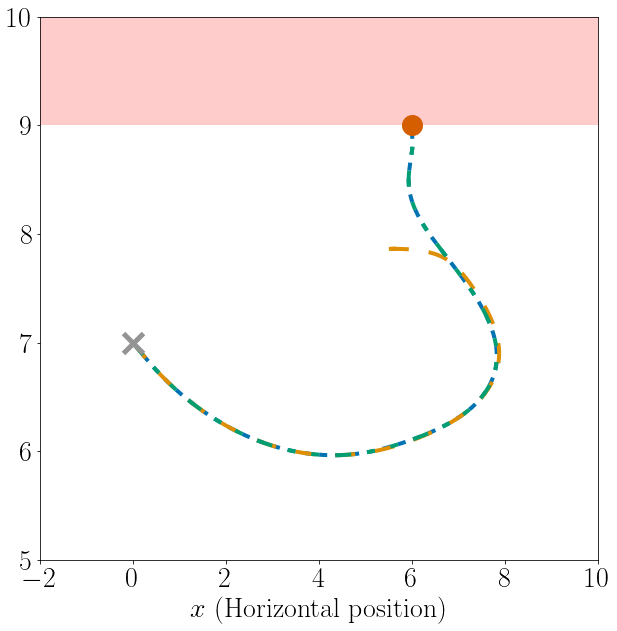

In [59]:
traj_data = pkl.load(open("quad_2d/traj_data_conservative_cbf.pkl", "rb"))
nominal = traj_data['nominal']
cbf_traj = traj_data['cbf']
cbvf_traj = traj_data['cbvf']
states = nominal['state']
control = nominal['control']
ts = nominal['times']
states_filt = cbf_traj['state']
control_filt = cbf_traj['control']
vf_filt = cbf_traj['vf']
states_filt_ws = cbvf_traj['state']
control_filt_ws = cbvf_traj['control']
vf_filt_ws = cbvf_traj['vf']
x_goal = traj_data['x_goal']
x0 = traj_data['x_start']



fig, ax = plt.subplots(figsize=(10,10))
sns.set_palette("colorblind")
lim = -1
# ax.contourf(extended_grid.coordinate_vectors[0], extended_grid.coordinate_vectors[2], new_vf_vals[:, 2, :, 13, 15, 13].T, levels=[0, 100], colors='green', alpha=.2)
c1 = ax.plot(np.array(states)[:lim, 0], np.array(states)[:lim, 2], '--', dashes=(2, 2), label= '$u_{nom}$')
c2 = ax.plot(np.array(states_filt)[:lim, 0], np.array(states_filt)[:lim, 2], ':', dashes=(5,5),label='$u_{CBF}$')
c3 = ax.plot(np.array(states_filt_ws)[:lim, 0], np.array(states_filt_ws)[:lim, 2], label='$u_{CBVF}$')
c3[0].set_dashes([4, 4, 2, 4, 2, 4]) 
# c1 = ax.plot(np.array(states)[:lim, 0], np.array(states)[:lim, 2], '--',  dashes=(5, 20), color=c1[0].get_color(), label= '__nolegend__')
l1 = ax.plot(x0[0], x0[2], 'x', markersize=20, mew=5, color=pal[7])
# ax.plot(np.array(states_filt)[-1, 0], np.array(states_filt)[-1, 2], 'x', markersize=20, mew=5, color=c2[0].get_color())
# ax.plot(np.array(states_filt_ws)[-1, 0], np.array(states_filt_ws)[-1, 2], 'x', markersize=20, mew=5, color=c3[0].get_color())
l2 = ax.plot(x_goal[0], x_goal[2], 'o', markersize=20, color=pal[3])

miscs = [l1, l2]
new_vals_broadcast = np.repeat(np.repeat(safe_values[np.newaxis, ...], 5, axis=0)[np.newaxis, ...], 5, axis=0)
ax.contourf(extended_grid.coordinate_vectors[0], extended_grid.coordinate_vectors[2], new_vals_broadcast[:, 2, :, 13, 20, 13].T, levels=[-100, 0], colors='r', alpha=.2)
# get_drone(ax, x0[0], x0[2], x0[4])
ax.set_xlim([-2, 10])
ax.set_ylim([5,10])
ax.set_xlabel('$x$ (Horizontal position)')
# ax.set_ylabel('$y$ (Height)')
# ax.legend(bbox_to_anchor=[.5, 0.9], ncol=3, columnspacing=0.6, handletextpad=0.3, loc='center')

(0.0, 7.99)

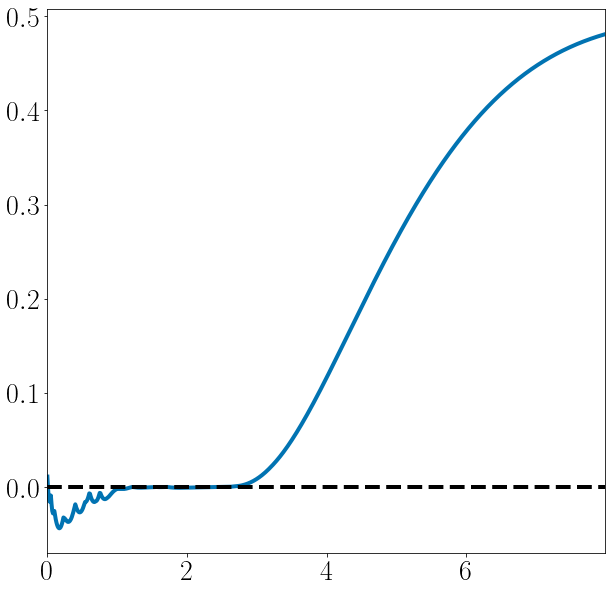

In [98]:
fig, ax = plt.subplots(figsize=(10,10))
# ax.plot(ts[:len(vf_filt)-1], vf_filt[1:])
ax.plot(ts, vf_filt_ws[1:])

ax.plot(ts, np.zeros_like(vf_filt_ws[1:]), '--k')
ax.set_xlim([ts[0], ts[-1]])

(0.0, 8.0)

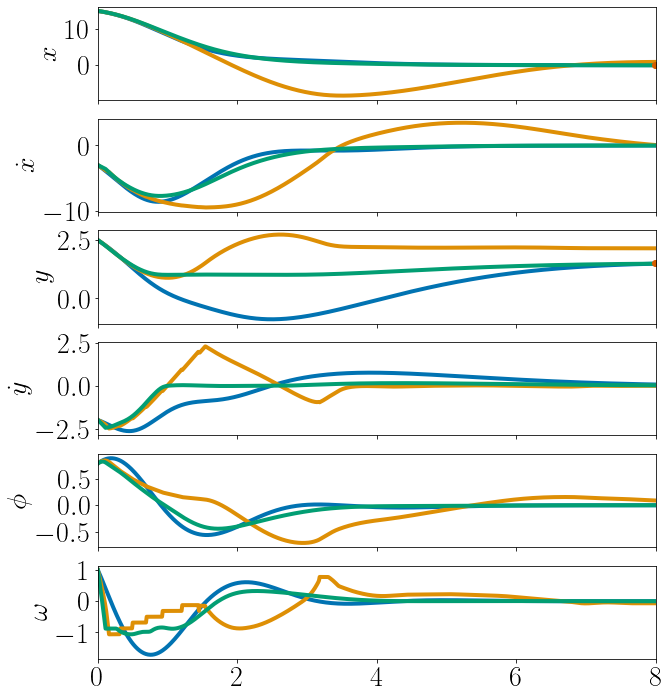

In [160]:
fig, ax = plt.subplots(6, 1, figsize=(10,12), sharex=True)
ax[0].plot(ts, np.array(states)[:-1, 0], label="$x$")
ax[0].plot(ts, np.array(states_filt)[:-1, 0], label="$x_{filt}$")
ax[0].plot(ts, np.array(states_filt_ws)[:-1, 0], label="$x_{filtered}$")
ax[0].plot(ts[-1], x_goal[0], 'o', label="$y_{target}$")
ax[1].plot(ts, np.array(states)[:-1, 1], label="$\dot x$")
ax[1].plot(ts, np.array(states_filt)[:-1, 1], label="$\dot x_{filt}$")
ax[1].plot(ts, np.array(states_filt_ws)[:-1, 1], label="$\dot x_{filtered}$")
ax[2].plot(ts, np.array(states)[:-1, 2], label="$y$")
ax[2].plot(ts, np.array(states_filt)[:-1, 2], label="$y_{filt}$")
ax[2].plot(ts, np.array(states_filt_ws)[:-1, 2], label="$y_{filtered}$")
ax[2].plot(ts[-1], x_goal[2], 'o', label="$y_{target}$")
ax[3].plot(ts, np.array(states)[:-1, 3], label="$\dot y$")
ax[3].plot(ts, np.array(states_filt)[:-1, 3], label="$\dot y_{filt}$")
ax[3].plot(ts, np.array(states_filt_ws)[:-1, 3], label="$\dot y_{filtered}$")
ax[4].plot(ts, np.array(states)[:-1, 4], label="$\phi$")
ax[4].plot(ts, np.array(states_filt)[:-1, 4], label="$\phi_{filt}$")
ax[4].plot(ts, np.array(states_filt_ws)[:-1, 4], label="$\phi_{filtered}$")
ax[5].plot(ts, np.array(states)[:-1, 5], label="$\omega$")
ax[5].plot(ts, np.array(states_filt)[:-1, 5], label="$\omega_{filt}$")
ax[5].plot(ts, np.array(states_filt_ws)[:-1, 5], label="$\omega_{filtered}$")
ax[0].set_ylabel('$x$')
ax[1].set_ylabel('$\dot x$')
ax[2].set_ylabel('$y$')
ax[3].set_ylabel('$\dot y$')
ax[4].set_ylabel('$\phi$')
ax[5].set_ylabel('$\omega$')
ax[5].set_xlim([0, ts[1] + ts[-1]])

In [227]:
import pickle as pkl
traj_data = dict()
traj_data['nominal'] = {'times': ts, 'state': np.array(states), 'control': np.array(control)}
traj_data['cbf'] = {'times': ts, 'state': np.array(states_filt), 'control': np.array(control_filt), 'vf': np.array(vf_filt)}
traj_data['cbvf'] = {'times': ts, 'state': np.array(states_filt_ws), 'control': np.array(control_filt_ws), 'vf': np.array(vf_filt_ws)}
traj_data['x_start'] = x0
traj_data['x_goal'] = x_goal
traj_data['target_values'] = target_values
pkl.dump(traj_data, open("quad_2d/traj_data_conservative_cbf.pkl", "wb"))

In [228]:
pkl.load(open("quad_2d/traj_data_invalid_cbf.pkl", "rb"))
nominal = traj_data['nominal']
cbf_traj = traj_data['cbf']
cbvf_traj = traj_data['cbvf']
states = nominal['state']
control = nominal['control']
ts = nominal['times']
states_filt = cbf_traj['state']
control_filt = cbf_traj['control']
vf_filt = cbf_traj['vf']
states_filt_ws = cbvf_traj['state']
control_filt_ws = cbvf_traj['control']
vf_filt_ws = cbvf_traj['vf']

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(ts, np.array(control)[:, 0], label="$u_1$")
ax.plot(ts, np.array(control)[:, 1], label="$u_2$")
ax.plot(ts, np.array(control_filt_ws)[:, 0], label="$u_1$")
ax.plot(ts, np.array(control_filt_ws)[:, 1], label="$u_2$")
ax.plot(ts, control_at_rest[0] * np.ones_like(ts), '--k')

In [ ]:
from refine_cbfs.utils.visualize_vf import animate_planar_quad

In [ ]:
fig, ani = animate_planar_quad(ts, np.array(states)[:,0], np.array(states)[:,2], np.array(states)[:,4])

In [ ]:
ani.save("quad_2d/invalid_lol.mp4", writer='ffmpeg', fps=30)